In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

In [69]:
df = pd.read_csv('transactions-2023-01-11.csv')

In [70]:
def drop_excess_columns(data):
    # Drop high cardinality columns
    data = data.drop(columns=["Transaction Number", "Property ID", "Transaction Size (sq.m)", "Parking", "Project"])
    # Drop low-cardinality columns
    data = data.drop(columns=["Master Project"])
#     data = data.drop(columns=["Registration type", "Master Project"])
    # Drop leaky columns
#     data = data.drop(columns=["Transaction sub type", "Property Type", "Room(s)", "No. of Buyer", "No. of Seller"])
    return data


In [71]:
df = drop_excess_columns(df)

In [72]:
def get_oil_price():
    # data from https://tradingeconomics.com/commodity/crude-oil
    r = requests.get('https://markets.tradingeconomics.com/chart?s=cl1:com&interval=1d&span=5y&securify=new&url=/commodity/crude-oil&AUTH=xiZaNUsZluCrXrQig2zoeyzzDe5ze2StGcGLnyJ53wZGuT7um2hWKUc%2BUSKjkBp9&ohlc=0')
    
    oil_data = pd.DataFrame(r.json()['series'][0]['data']).rename(columns={"y": "Oil Price"})
    oil_data = oil_data[(oil_data['date'] > '2021-03-01') & (oil_data['date'] < '2022-02-04')]

    return oil_data[['date', 'Oil Price']]
    

In [73]:
oil_data = get_oil_price()
oil_data

,date,Oil Price
853,2021-03-01T00:00:00,60.64
854,2021-03-02T00:00:00,59.75
855,2021-03-03T00:00:00,61.28
856,2021-03-04T00:00:00,63.83
857,2021-03-05T00:00:00,66.09
...,...,...
1089,2022-01-28T00:00:00,85.43
1090,2022-01-31T00:00:00,86.49
1091,2022-02-01T00:00:00,86.46
1092,2022-02-02T00:00:00,86.69


In [74]:
def drop_period_after_war(data):
    war_date = '2022-02-24'
    return data[data['Transaction Date'] < war_date]

In [75]:
df = drop_period_after_war(df)

In [76]:
def merge_oil_to_data(data, oil):
    data['date_without_time'] = pd.to_datetime(data['Transaction Date']).dt.strftime('%Y-%m-%d')
    oil['date_without_time'] = pd.to_datetime(oil['date']).dt.strftime('%Y-%m-%d')
    data = data.merge(oil, left_on='date_without_time', right_on='date_without_time')
    return data

In [77]:
df = merge_oil_to_data(df, oil_data)

In [78]:
df.to_csv('prepared_data.csv')

In [88]:
df["Room(s)"]

0         2 B/R
1         1 B/R
2         1 B/R
3         2 B/R
4        Studio
          ...  
69700     1 B/R
69701       NaN
69702       NaN
69703       NaN
69704     3 B/R
Name: Room(s), Length: 69705, dtype: object

In [109]:
def clean_outliers_in_data(data):
    quantiles = data.quantile(0.80)
    data = data[(data['Amount'] < quantiles['Amount']) & (data['Property Size (sq.m)'] < quantiles['Property Size (sq.m)'])]
    data = data[(data['Property Size (sq.m)'] != 1393.55)]
    data = data[data['Property Sub Type'].isin(["Commercial", "Flat", "Hotel Apartment", "Hotel Rooms",  "Office", "Residential", "Residential / Attached Villas","Residential Flats", "Stacked Townhouses", "Villa"])]
    
    # replace nan
    
    data['Nearest Metro'] = data['Nearest Metro'].apply(lambda m: 1 if m else 0)
    data['Nearest Mall'] = data['Nearest Mall'].apply(lambda m: 1 if m else 0)  
    data["Room(s)"] = data["Room(s)"].fillna("2 B/R")
    
    data = data.dropna()
    return data

In [110]:
cleaned_df = clean_outliers_in_data(df)

/var/folders/41/gxq0b1712fbb5k5ndrr4d4cw0000gn/T/ipykernel_83956/1607080342.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantiles = data.quantile(0.80)


In [111]:
cleaned_df

,Transaction Date,Transaction Type,Transaction sub type,Registration type,Is Free Hold?,Usage,Area,Property Type,Property Sub Type,Amount,Property Size (sq.m),Room(s),Nearest Metro,Nearest Mall,Nearest Landmark,No. of Buyer,No. of Seller,date_without_time,date,Oil Price
0,2021-03-02 13:53:10,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,AL BARARI,Unit,Flat,1435909.09,138.93,2 B/R,1,1,IMG World Adventures,0,0,2021-03-02,2021-03-02T00:00:00,59.75
1,2021-03-02 13:53:10,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,AL BARARI,Unit,Flat,1435909.09,87.26,1 B/R,1,1,IMG World Adventures,0,0,2021-03-02,2021-03-02T00:00:00,59.75
2,2021-03-02 13:53:10,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,AL BARARI,Unit,Flat,1435909.09,76.13,1 B/R,1,1,IMG World Adventures,0,0,2021-03-02,2021-03-02T00:00:00,59.75
3,2021-03-02 13:53:10,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,AL BARARI,Unit,Flat,1435909.09,130.05,2 B/R,1,1,IMG World Adventures,0,0,2021-03-02,2021-03-02T00:00:00,59.75
4,2021-03-02 13:53:10,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,AL BARARI,Unit,Flat,1435909.09,52.15,Studio,1,1,IMG World Adventures,0,0,2021-03-02,2021-03-02T00:00:00,59.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69696,2021-07-16 16:59:05,Mortgage,Delayed Mortgage,Ready,Free Hold,Residential,BUSINESS BAY,Unit,Flat,1920000.00,182.93,3 B/R,1,1,Downtown Dubai,0,0,2021-07-16,2021-07-16T00:00:00,71.81
69697,2021-07-23 02:46:49,Mortgage,Mortgage Registration,Ready,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Unit,Hotel Rooms,262500.00,44.90,Studio,1,1,Sports City Swimming Academy,0,0,2021-07-23,2021-07-23T00:00:00,72.07
69698,2021-07-23 02:49:20,Mortgage,Mortgage Registration,Ready,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Unit,Hotel Rooms,262500.00,44.91,Studio,1,1,Sports City Swimming Academy,0,0,2021-07-23,2021-07-23T00:00:00,72.07
69699,2021-07-23 03:05:48,Mortgage,Mortgage Registration,Ready,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Unit,Flat,628000.00,94.02,1 B/R,1,1,Sports City Swimming Academy,0,0,2021-07-23,2021-07-23T00:00:00,72.07


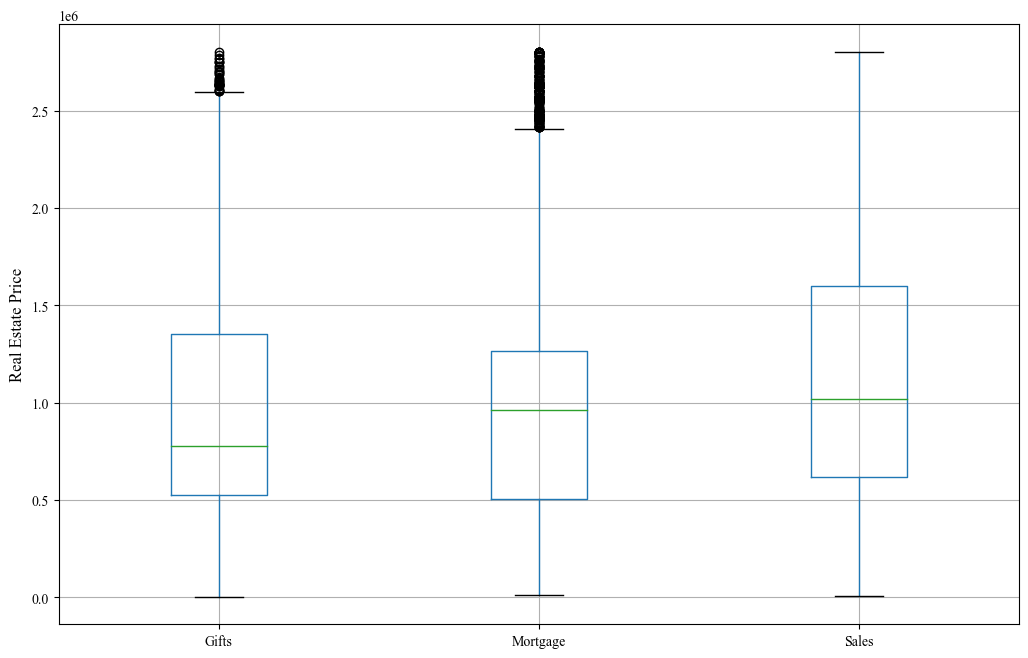

In [115]:
plt.rcParams["font.family"] = "Times New Roman"

ax = cleaned_df[['Transaction Type', 'Amount']].boxplot(by="Transaction Type", figsize=(12, 8))

ax.set_xlabel("")

ax.set_ylabel("Real Estate Price", fontname="Times New Roman", fontsize=12)

ax.set_label("")


ax.get_figure().gca().set_xlabel("")
ax.get_figure().suptitle('')

ax.set_title("", fontname="Times New Roman", fontsize=18)

plt.savefig('images/Transaction_Type.png', dpi=300)

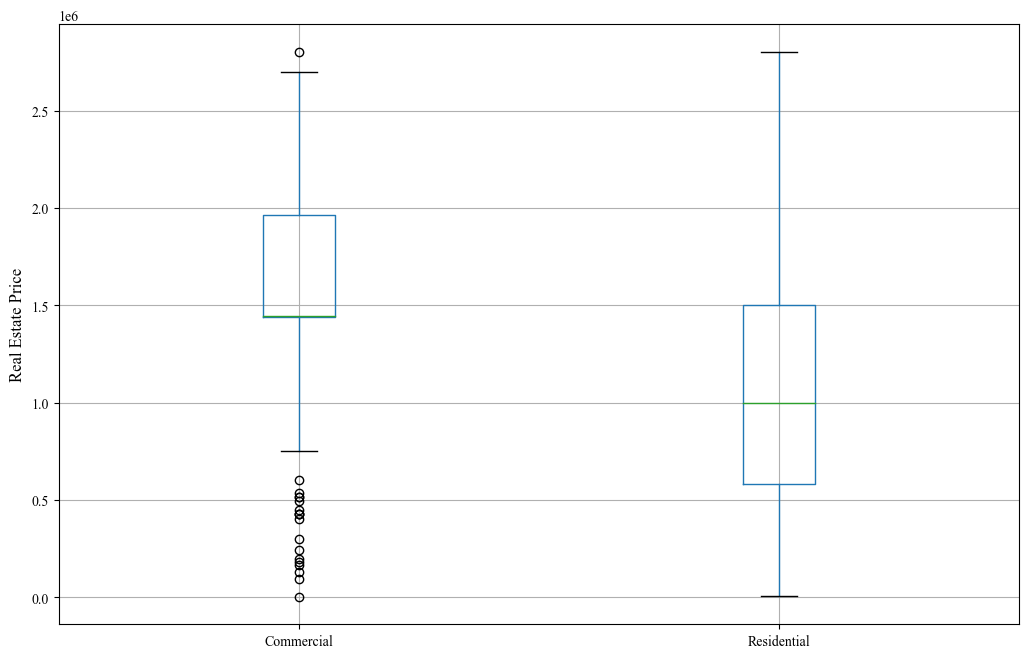

In [116]:
plt.rcParams["font.family"] = "Times New Roman"

ax = cleaned_df[['Usage', 'Amount']].boxplot(by="Usage", figsize=(12, 8))

ax.set_xlabel("")

ax.set_ylabel("Real Estate Price", fontname="Times New Roman", fontsize=12)

ax.set_label("")


ax.get_figure().gca().set_xlabel("")
ax.get_figure().suptitle('')

ax.set_title("", fontname="Times New Roman", fontsize=18)

plt.savefig('images/Usage.png', dpi=300)

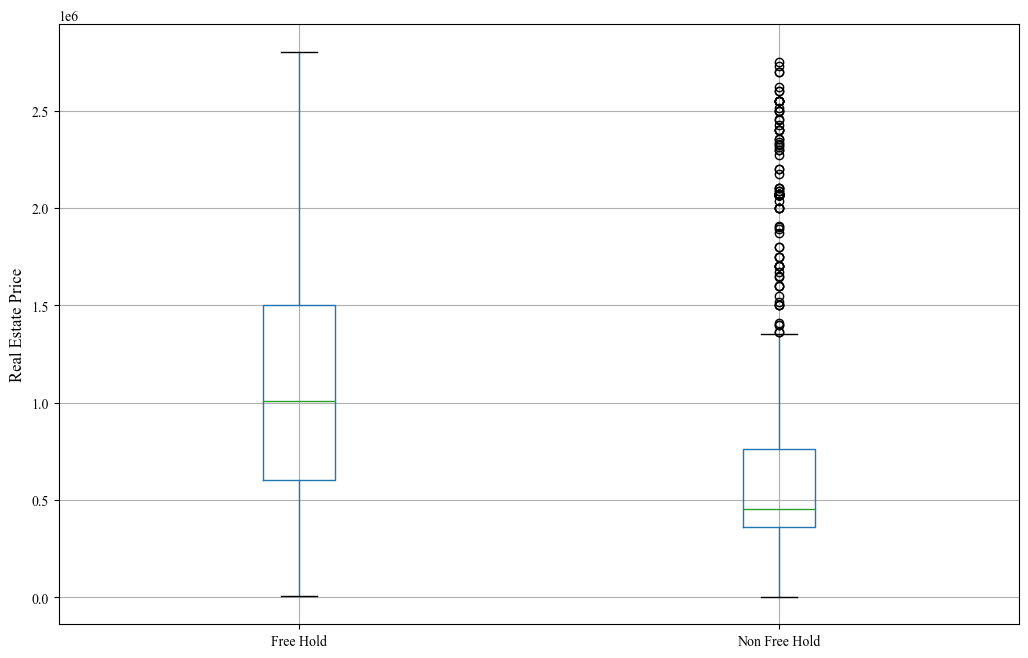

In [117]:
plt.rcParams["font.family"] = "Times New Roman"

ax = cleaned_df[['Is Free Hold?', 'Amount']].boxplot(by="Is Free Hold?", figsize=(12, 8))

ax.set_xlabel("")

ax.set_ylabel("Real Estate Price", fontname="Times New Roman", fontsize=12)

ax.set_label("")


ax.get_figure().gca().set_xlabel("")
ax.get_figure().suptitle('')

ax.set_title("", fontname="Times New Roman", fontsize=18)

plt.savefig('images/Is_Free_Hold?.png', dpi=300)

In [102]:
from pandas.plotting import scatter_matrix

test = cleaned_df[(cleaned_df['Property Size (sq.m)'] > 1392) & (cleaned_df['Property Size (sq.m)'] < 1394)]

# scatter_matrix(test[['Amount', 'Property Size (sq.m)']], figsize=(12, 8))

In [103]:
from pandas.plotting import scatter_matrix

def plot_matrix(data):
    scatter_matrix(data[['Amount', 'Property Size (sq.m)']], figsize=(12, 8))
    scatter_matrix(data[['Amount', 'Oil Price']], figsize=(12, 8))
    return data['Property Size (sq.m)'].describe()

count    52488.000000
mean       165.661995
std        164.846502
min          7.300000
25%         71.130000
50%        112.360000
75%        183.567500
max       1084.460000
Name: Property Size (sq.m), dtype: float64

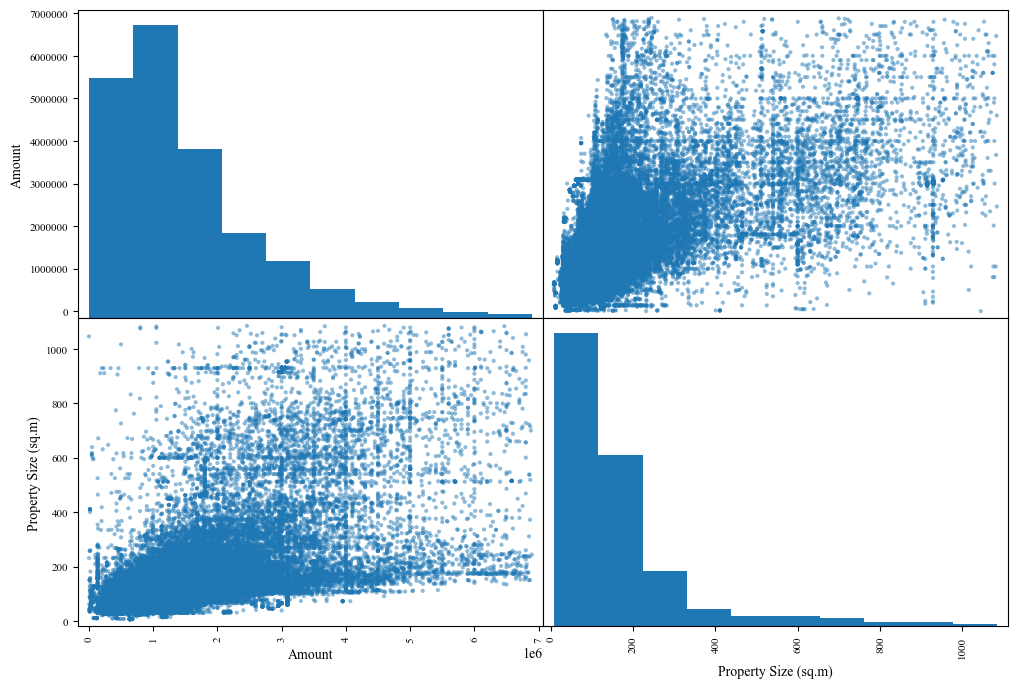

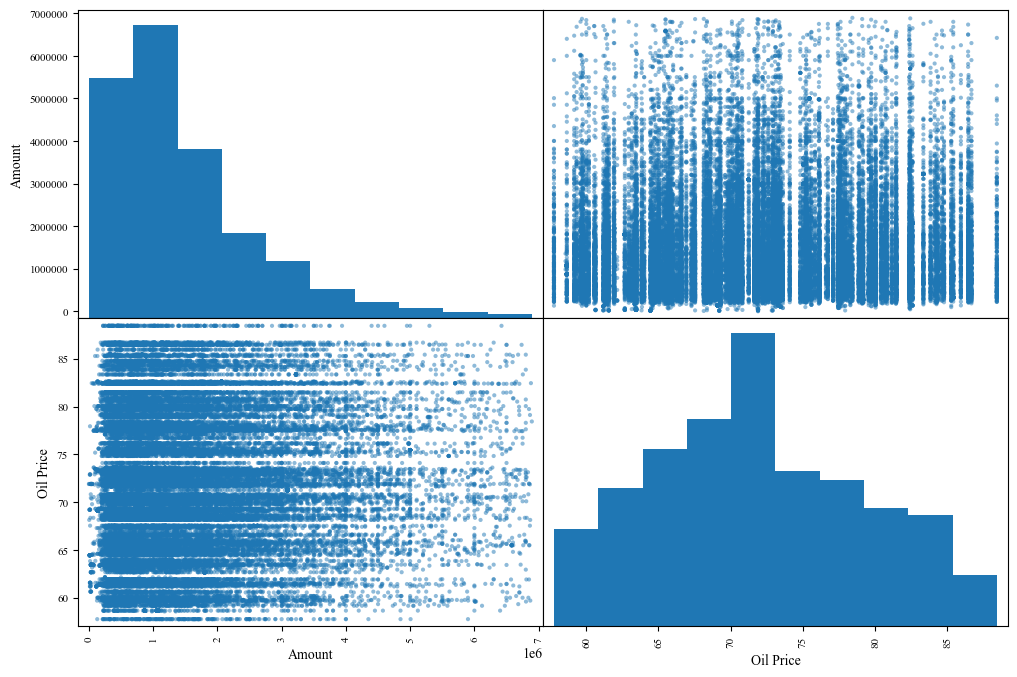

In [104]:
plot_matrix(cleaned_df)

In [105]:
def preparing_data_before_training(data, drop, renameColumns):
    data = data.drop(drop, axis=1)
    data = data.rename(columns=renameColumns)
    return data

In [106]:
prepared_data = preparing_data_before_training(
    cleaned_df, 
    ['date_without_time', 'Transaction Date', 'date'],
    {
        'Property Size (sq.m)': 'Property_Size',
        'Property Sub Type': 'Property_Sub_Type',
        'Nearest Metro': 'Nearest_Metro',
        'Nearest Mall': 'Nearest_Mall',
        'Nearest Landmark': 'Nearest_Landmark',
        'Oil Price': 'Oil_Price',
        'Transaction Type': 'Transaction_Type',
        "Is Free Hold?": 'Is_Free_Hold'
    }
)

In [107]:
import statsmodels.formula.api as smf

sm_data = sm.add_constant(prepared_data)
model = smf.ols(formula='Amount ~ C(Transaction_Type) + C(Usage) + C(Area) + C(Property_Sub_Type) + Property_Size + C(Nearest_Metro) + C(Nearest_Mall) + C(Nearest_Landmark) + Oil_Price + C(Is_Free_Hold)', data=sm_data)
results = model.fit()


In [108]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Amount   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     624.4
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:29:45   Log-Likelihood:            -7.7842e+05
No. Observations:               52488   AIC:                         1.557e+06
Df Residuals:                   52314   BIC:                         1.559e+06
Df Model:                         173                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                           -7.502e+05      1e+05     -7.479      0.000   -9.47e+05   -5.54e+05
C(Transaction_Type)[T.Mortgage]                     -1.127e+05   1.58e+04     -7.148      0.000   -1.44e+05   -8.18e+04
C(Transaction_Type)[T.Sales]                         3.623e+05   1.52e+04     23.875      0.000    3.33e+05    3.92e+05
C(Usage)[T.Residential]                             -1.017e+05   2.84e+04     -3.586      0.000   -1.57e+05   -4.61e+04
C(Area)[T.AL BARARI]                                 7.713e+05   9.02e+04      8.547      0.000    5.94e+05    9.48e+05
C(Area)[T.AL FURJAN]                                 5.205e+05    9.1e+04      5.722      0.000    3.42e+05    6.99e+05
C(Area)[T.AL KHAIL HEIGHTS]                           1.15e+06   1.76e+05      6.543      0.000    8.05e+05    1.49e+06
C(Area)[T.AL WAHA]                                  -2.369e+05   8.42e+04     -2.815      0.005   -4.02e+05   -7.19e+04
C(Area)[T.ARABIAN RANCHES I]                          2.84e+05   7.75e+04      3.666      0.000    1.32e+05    4.36e+05
C(Area)[T.ARABIAN RANCHES II]                        4.307e+05      8e+04      5.388      0.000    2.74e+05    5.87e+05
C(Area)[T.ARABIAN RANCHES III]                       3.847e+05   1.03e+05      3.728      0.000    1.82e+05    5.87e+05
C(Area)[T.ARJAN]                                     2.311e+05   7.49e+04      3.085      0.002    8.43e+04    3.78e+05
C(Area)[T.Abu Hail]                                  1.945e+06   4.54e+05      4.284      0.000    1.06e+06    2.83e+06
C(Area)[T.Al Bada]                                   1.171e+06   2.63e+05      4.461      0.000    6.57e+05    1.69e+06
C(Area)[T.Al Baraha]                                 4.753e+06   4.71e+05     10.085      0.000    3.83e+06    5.68e+06
C(Area)[T.Al Barsha First]                            8.38e+05    4.8e+05      1.747      0.081   -1.02e+05    1.78e+06
C(Area)[T.Al Barsha Third]                          -1.615e+06   6.76e+05     -2.389      0.017   -2.94e+06    -2.9e+05
C(Area)[T.Al Barshaa South First]                   -3.479e+06   6.75e+05     -5.155      0.000    -4.8e+06   -2.16e+06
C(Area)[T.Al Barshaa South Third]                    -1.51e+05   3.93e+05     -0.384      0.701   -9.21e+05    6.19e+05
C(Area)[T.Al Dhagaya]                                4.683e+06   5.43e+05      8.626      0.000    3.62e+06    5.75e+06
C(Area)[T.Al Garhoud]                                1.884e+06   4.95e+05      3.809      0.000    9.14e+05    2.85e+06
C(Area)[T.Al Goze First]                            -9.884e+05   2.26e+05     -4.367      0.000   -1.43e+06   -5.45e+05
C(Area)[T.Al Goze Fourth]                            2.713e+05   5.04e+05      0.53

In [ ]:
fig = sm.graphics.plot_regress_exog(results, "Property_Size")
fig.tight_layout(pad=1.0)

In [ ]:
pred_ols = results.get_prediction()

fig, ax = plt.subplots(figsize=(8, 6))

x = prepared_data['Property_Size']
y = prepared_data['Amount']

ax.plot(x, y, "o", label="data")
ax.plot(x, results.fittedvalues, "o", label="OLS")

ax.legend(loc="best")